# 1.6 Error estimation & adaptive refinement


In this tutorial, we apply a Zienkiewicz-Zhu type error estimator and run an adaptive loop with these steps:
$$
\text{Solve}\rightarrow
\text{Estimate}\rightarrow
\text{Mark}\rightarrow
\text{Refine}\rightarrow
\text{Solve} \rightarrow \ldots
$$

In [1]:
import netgen.gui
%gui tk
from ngsolve import *
from netgen.geom2d import SplineGeometry
import matplotlib.pyplot as plt

### Geometry

The following geometry represents a heating chip embedded in another material that conducts away the heat.

In [2]:
#   point numbers 0, 1, ... 11
#   sub-domain numbers (1), (2), (3)
#  
#
#             7-------------6
#             |             |
#             |     (2)     |
#             |             |
#      3------4-------------5------2
#      |                           |
#      |             11            |
#      |           /   \           |
#      |         10 (3) 9          |
#      |           \   /     (1)   |
#      |             8             |
#      |                           |
#      0---------------------------1
#

def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,2,1,0), (2,5,2,1,0), (5,4,2,1,2), (4,3,2,1,0), (3,0,2,1,0), \
              (5,6,2,2,0), (6,7,2,2,0), (7,4,2,2,0), \
              (8,9,2,3,1), (9,10,2,3,1), (10,11,2,3,1), (11,8,2,3,1) ]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append(["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)

    geometry.SetMaterial(1,"base")
    geometry.SetMaterial(2,"chip")
    geometry.SetMaterial(3,"top")    

    return geometry

mesh = Mesh(MakeGeometry().GenerateMesh(maxh=0.2))

### Spaces & forms

The problem is to find $u$ in $H_{0,D}^1$ satisfying 

$$
\int_\Omega \lambda \nabla u \cdot \nabla v = \int_\Omega f v 
$$

for all $v$ in $H_{0,D}^1$. We expect the solution to have singularities due to the nonconvex re-enrant angles and discontinuities in $\lambda$.

In [3]:
fes = H1(mesh, order=3, dirichlet=[1])
u, v = fes.TnT()

# one heat conductivity coefficient per sub-domain
lam = CoefficientFunction([1, 1000, 10])
a = BilinearForm(fes)
a += SymbolicBFI(lam*grad(u)*grad(v))

# heat-source in inner subdomain
f = LinearForm(fes)
f += SymbolicLFI(CoefficientFunction([0, 0, 1])*v)

c = Preconditioner(a, type="multigrid", inverse="sparsecholesky")

gfu = GridFunction(fes)
Draw (gfu)

Note that the linear system is not yet assembled above.

### Solve 

Since we must solve multiple times, we define a function to solve the boundary value problem, where assembly, update, and solve occurs.

In [4]:
def SolveBVP():
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)

In [5]:
SolveBVP()

### Estimate

We implement a gradient-recovery-type error estimator. For this, we need an H(div) space for flux recovery. We must compute the flux  of the computed solution and interpolate it into this H(div) space.

In [6]:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

flux = lam * grad(gfu)
gf_flux.Set(flux)

In [7]:
err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
Draw(err, mesh, 'error_representation')

**Element-wise error estimator:** On each element $T$, set 

$$
\eta_T^2 = \int_T \frac{1}{\lambda} 
|\lambda \nabla u_h - I_h(\lambda \nabla u_h) |^2
$$

where $u_h$ is the computed solution `gfu` and $I_h$ is the interpolation performed by `Set` in NGSolve.


In [8]:
eta2 = Integrate(err, mesh, VOL, element_wise=True)
print(eta2)

 2.36461e-10
 1.18698e-08
 5.03613e-06
 6.34682e-11
 4.33101e-11
 1.7484e-11
 1.58609e-10
 6.33751e-09
 1.19293e-10
 1.35243e-07
 1.98437e-07
 2.00923e-07
 1.16473e-08
 1.251e-07
 2.2953e-07
 5.73909e-09
 3.385e-11
 3.31297e-10
 3.32684e-10
 3.89806e-07
 2.26934e-07
 2.60348e-07
 3.3506e-07
 8.52564e-10
 2.40196e-06
 3.57631e-06
 2.45321e-08
 1.29118e-10
 8.8645e-08
 3.87456e-08
 1.6248e-07
 7.55763e-08
 3.12331e-06
 3.79783e-10
 1.90566e-07
 1.04137e-09
 6.8768e-07
 7.2601e-07
 3.8487e-07
 1.43514e-10
 1.35152e-10
 6.55815e-07
 1.82416e-07
 7.13649e-08
 9.56596e-09
 6.74125e-09
 3.28339e-10
 2.90424e-09
 5.48405e-08
 1.15509e-08
 1.45004e-08
 2.01172e-08
 1.37504e-08
 1.13422e-07
 3.51327e-08
 1.27836e-10
 5.86447e-12
 4.22009e-12
 3.1807e-10
 5.72781e-13
 1.2421e-11
 5.4183e-12
 2.41244e-10
 6.65466e-07
 8.8388e-08



The above values, one per element, lead us to identify elements which might have large error.


### Mark 

We mark elements with large error estimator for refinement.

In [9]:
maxerr = max(eta2)
print ("maxerr = ", maxerr)

for el in mesh.Elements():
    mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)
    
Draw(gfu)

maxerr =  5.036125830814317e-06


### Refine & solve again 

Refine marked elements:

In [10]:
mesh.Refine()
SolveBVP()
Redraw()

### Automate the above steps

In [11]:
l = []    # l = list of estimated total error

def CalcError():

    # compute the flux:
    space_flux.Update()      
    gf_flux.Update()
    flux = lam * grad(gfu)        
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " maxerr =", maxerr)
    
    # mark for refinement:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)

In [12]:
CalcError()
mesh.Refine()

ndof = 445  maxerr = 2.511445609726963e-06


### Run the adaptive loop

In [13]:
while fes.ndof < 50000:  
    SolveBVP()
    CalcError()
    mesh.Refine()

ndof = 664  maxerr = 9.300425565031251e-07
ndof = 1192  maxerr = 3.414646836906428e-07
ndof = 1834  maxerr = 2.1472585059819264e-07
ndof = 2167  maxerr = 9.835056165137945e-08
ndof = 2839  maxerr = 4.917040165457557e-08
ndof = 3466  maxerr = 2.458740959858597e-08
ndof = 3805  maxerr = 1.2294699792242802e-08
ndof = 4450  maxerr = 6.145986051434467e-09
ndof = 5257  maxerr = 3.071914052546866e-09
ndof = 5713  maxerr = 1.5353408223467698e-09
ndof = 6475  maxerr = 7.673155137357938e-10
ndof = 7165  maxerr = 3.8347357373724957e-10
ndof = 7900  maxerr = 1.9164536414781034e-10
ndof = 8719  maxerr = 9.577670728615699e-11
ndof = 9853  maxerr = 4.7867485757047704e-11
ndof = 10810  maxerr = 2.392324427586057e-11
ndof = 11884  maxerr = 1.1956352408132547e-11
ndof = 13513  maxerr = 5.975487707207399e-12
ndof = 15553  maxerr = 2.986452644572587e-12
ndof = 17776  maxerr = 1.4925627796160417e-12
ndof = 20404  maxerr = 7.459783254409289e-13
ndof = 23653  maxerr = 3.7281573519588415e-13
ndof = 27394  max

### Plot history of adaptive convergence

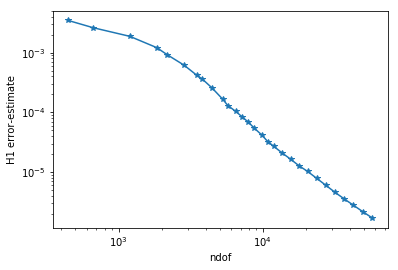

In [14]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show()